In [1]:
from sklearn.cluster import KMeans
import torch
from torch.nn import Embedding
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import Parameter
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from torch_geometric.datasets import Planetoid
import copy
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.datasets import KarateClub
EPS = 1e-15

In [17]:
def predict_acc(recons_edges, true_edges):
    predict_graph = recons_edges
    predict_edges = np.array(predict_graph)
    print("AP SCORE： ",average_precision_score(true_edges, predict_edges))
    print("AUC SCORE: ",roc_auc_score(true_edges, predict_edges))
    #return average_precision_score(true_edges, predict_edges), roc_auc_score(true_edges, predict_edges)

In [53]:
"""  Given the cluster centroids, update the node representation  """
class reconstruction_graph(nn.Module):
    def __init__(self, NE, alpha=1.0):
        super(reconstruction_graph, self).__init__()
        self.alpha = alpha
        self.nodes_embedding = Parameter(NE)
        
    def forward(self, CC):
        # Calculate the attention score (in nodes) for each node to each cluster
        norm_squared = torch.sum((self.nodes_embedding.unsqueeze(1) - CC)**2, 2)   # Distance from the node to the center of mass
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        power = float(self.alpha + 1) / 2   
        numerator = numerator**power    
        soft_assignments = (numerator.t() / torch.sum(numerator, 1)).t()       #soft assignment using t-distribution
        
        # Calculate the cluster similarity between nodes (cosine similarity): the larger the value, the more conducive to edge formation
        prod = torch.mm(soft_assignments, soft_assignments.t())       #  numerator
        norm = torch.norm(soft_assignments,p=2,dim=1).unsqueeze(0)      #    denominator 
        clusters_similar = prod.div(torch.mm(norm.t(),norm))
        
        # Calculate the distance between nodes: smaller values favor edge formation
        nodes_distance = torch.norm(self.nodes_embedding[:, None]-self.nodes_embedding, dim=2, p=2)
        nodes_distance = torch.div(nodes_distance, torch.max(nodes_distance))
        
        # The formation probability of the edges is calculated
        distance_similar = torch.div(beta*nodes_distance, clusters_similar)      
        nodes_similar = torch.exp(-distance_similar)
        
        return nodes_similar

class update_nodes_embedding(nn.Module):
    def __init__(self, ne):
        super(update_nodes_embedding, self).__init__()
        NE = ne
        self.reconstruction_module = reconstruction_graph(NE)     
        self.optimizer = torch.optim.SGD(params=self.reconstruction_module.parameters(), lr=0.1, momentum=0.9)
        self.loss_function = torch.nn.MSELoss(reduction='sum')
        
    def forward(self, g, CC, edge_train, edge_test):
        self.reconstruction_module.train()
        for epoch in range(10):
            self.optimizer.zero_grad()
            graph_reconstruction = self.reconstruction_module(CC)
            graph_train = torch.take(graph_reconstruction, edge_train)
            loss = self.loss_function(g, graph_train)
            loss.backward()
            self.optimizer.step()
            #print(f'Epoch: {epoch:02d}, Loss: {loss.item():.4f}')
        recons_test_edges = torch.take(graph_reconstruction, edge_test).detach()
        predict_acc(recons_test_edges, test_edge)
        return self.reconstruction_module.nodes_embedding.detach()

"""  Type-centroid update aimed at maximizing the prediction effect   """
class ClusteringLayer(nn.Module):
    """  Given the node representation, update the cluster centroids  """
    def __init__(self, cc, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.alpha = alpha
        self.cluster_centers = Parameter(cc)
    
    def forward(self, NE):
        norm_squared = torch.sum((NE.unsqueeze(1) - self.cluster_centers)**2, 2) 
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        power = float(self.alpha + 1) / 2   
        numerator = numerator**power   
        soft_assignments = (numerator.t() / torch.sum(numerator, 1)).t() 
        
        prod = torch.mm(soft_assignments, soft_assignments.t())
        norm = torch.norm(soft_assignments,p=2,dim=1).unsqueeze(0)
        clusters_similar = prod.div(torch.mm(norm.t(),norm))
        
        nodes_distance = torch.norm(NE[:, None]-NE, dim=2, p=2)
        nodes_distance = torch.div(nodes_distance, torch.max(nodes_distance))
        
        distance_similar = torch.div(beta*nodes_distance, clusters_similar)      
        nodes_similar = torch.exp(-distance_similar)
        
        return nodes_similar

def find_cluster_centers(NE, CC, g, edge_train, edge_test, num_epochs=10):        
    clusteringlayer = ClusteringLayer(CC)
    optimizer = torch.optim.SGD(params=clusteringlayer.parameters(), lr=0.1, momentum=0.9)
    loss_function = torch.nn.MSELoss(reduction='sum')
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        graph_recons = clusteringlayer(NE)
        graph_train = torch.take(graph_recons, edge_train)
        loss = loss_function(g, graph_train)
        loss.backward()
        optimizer.step()
        #print(f'Epoch: {epoch:02d}, Loss: {loss.item():.4f}')     
    recons_test_edges = torch.take(graph_recons, edge_test).detach()
    predict_acc(recons_test_edges, test_edge)
    return clusteringlayer.cluster_centers.detach()

In [54]:
def get_graph(nodes_number):
    # use all edges to train
    dataset = KarateClub()
    data = dataset[0]
    edges = data.edge_index
    start_nodes = np.array(edges[0])
    end_nodes = np.array(edges[1])
    
    graph_np = np.zeros((nodes_number, nodes_number))

    for i in range(edges.shape[1]):
        graph_np[start_nodes[i], end_nodes[i]]=1
    
    for i in range(nodes_number):
        graph_np[i,i]=1
    
    nega_edge = np.argwhere(graph_np == 0) 
    posi_edge = np.argwhere(graph_np == 1)
    posi_edge_number = posi_edge.shape[0]
    
    choose_positive = posi_edge
    choose_negative = nega_edge
    test_posi = [list(choose_positive[i]) for i in range(len(choose_positive))]
    test_nega = [list(choose_negative[i]) for i in range(len(choose_negative))]
    test_index = test_posi + test_nega
    test_mask = [test_index[i][0]*nodes_number+test_index[i][1] for i in range(len(test_index))]
    test_mask = torch.tensor(test_mask)
    
    train_positive = posi_edge
    train_negative = nega_edge
    train_posi = [list(train_positive[i]) for i in range(len(train_positive))]
    train_nega = [list(train_negative[i]) for i in range(len(train_negative))]
    train_index = train_posi + train_nega
    train_mask = [train_index[i][0]*nodes_number+train_index[i][1] for i in range(len(train_index))]
    train_mask = torch.tensor(train_mask)
    
    graph_tensor = torch.from_numpy(graph_np).float()
    train_edge = torch.take(graph_tensor, train_mask)
    test_edge = np.array(torch.take(graph_tensor, test_mask))
    
    return train_edge, test_edge, train_mask, test_mask

In [55]:
alpha = 1.0
nodes_number = 34
train_edge, test_edge, train_mask, test_mask = get_graph(nodes_number)

In [76]:
embedding_dim = 8
n_clusters = 12
alpha = 1
beta = 5

ini_embedding = Embedding(nodes_number, embedding_dim, sparse=True)       
raw_nodes_embedding = ini_embedding.weight.detach()        # Initial node embedding

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(raw_nodes_embedding)
cluster_centers = kmeans.cluster_centers_
raw_cluster_centers = torch.tensor(cluster_centers, dtype=torch.float)     # Initial cluster centroids
  
for module_epoch in range(300):
    print("######################### Module cycle ： %d ##########################"%module_epoch)
    update_nodes_module = update_nodes_embedding(raw_nodes_embedding)
    raw_nodes_embedding = update_nodes_module(train_edge, raw_cluster_centers, train_mask, test_mask)
    raw_cluster_centers = find_cluster_centers(raw_nodes_embedding, raw_cluster_centers, train_edge, train_mask, test_mask)

######################### Module cycle ： 0 ##########################
AP SCORE：  0.5089065229615312
AUC SCORE:  0.6150375939849625
AP SCORE：  0.5464268934683352
AUC SCORE:  0.6606952163016235
######################### Module cycle ： 1 ##########################
AP SCORE：  0.6724427793459978
AUC SCORE:  0.7578729432276343
AP SCORE：  0.7059909156170673
AUC SCORE:  0.8011332679524898
######################### Module cycle ： 2 ##########################
AP SCORE：  0.7313293736138771
AUC SCORE:  0.8308161708619375
AP SCORE：  0.7471187060892922
AUC SCORE:  0.851738040754059
######################### Module cycle ： 3 ##########################
AP SCORE：  0.7663013022723183
AUC SCORE:  0.8587773782281792
AP SCORE：  0.7729584817657641
AUC SCORE:  0.871395881006865
######################### Module cycle ： 4 ##########################
AP SCORE：  0.7820673195318525
AUC SCORE:  0.8787185354691076
AP SCORE：  0.790366306109215
AUC SCORE:  0.8861283643892339
######################### Module cycle ： 5 

AP SCORE：  0.914236283761554
AUC SCORE:  0.9790127492644655
AP SCORE：  0.9140486830914295
AUC SCORE:  0.9789691620355235
######################### Module cycle ： 45 ##########################
AP SCORE：  0.9148035874700339
AUC SCORE:  0.9791326141440557
AP SCORE：  0.9143429250513028
AUC SCORE:  0.9791217173368203
######################### Module cycle ： 46 ##########################
AP SCORE：  0.9147038396720356
AUC SCORE:  0.9794268279394138
AP SCORE：  0.9144421407732566
AUC SCORE:  0.97933965348153
######################### Module cycle ： 47 ##########################
AP SCORE：  0.9155758193346488
AUC SCORE:  0.9796665576985942
AP SCORE：  0.9151589388377624
AUC SCORE:  0.9796447640841234
######################### Module cycle ： 48 ##########################
AP SCORE：  0.9161183830886661
AUC SCORE:  0.9799062874577749
AP SCORE：  0.9160981457032511
AUC SCORE:  0.9799171842650103
######################### Module cycle ： 49 ##########################
AP SCORE：  0.9161036322408876
AUC SCOR

AUC SCORE:  0.9837637572191347
######################### Module cycle ： 89 ##########################
AP SCORE：  0.9216782393301775
AUC SCORE:  0.9837746540263703
AP SCORE：  0.9215552444037178
AUC SCORE:  0.9837637572191348
######################### Module cycle ： 90 ##########################
AP SCORE：  0.9214987428525966
AUC SCORE:  0.9837637572191349
AP SCORE：  0.9215107006926689
AUC SCORE:  0.9837855508336059
######################### Module cycle ： 91 ##########################
AP SCORE：  0.9216840480329805
AUC SCORE:  0.9838073444480767
AP SCORE：  0.9215715689065105
AUC SCORE:  0.9837855508336057
######################### Module cycle ： 92 ##########################
AP SCORE：  0.9216869069987689
AUC SCORE:  0.9838291380625477
AP SCORE：  0.9218608664405891
AUC SCORE:  0.9838400348697831
######################### Module cycle ： 93 ##########################
AP SCORE：  0.9216252937582082
AUC SCORE:  0.9838182412553123
AP SCORE：  0.921676258273569
AUC SCORE:  0.9838291380625477
#####

AUC SCORE:  0.9838509316770185
######################### Module cycle ： 134 ##########################
AP SCORE：  0.9198664536660123
AUC SCORE:  0.9838291380625477
AP SCORE：  0.9199449053234112
AUC SCORE:  0.9838509316770186
######################### Module cycle ： 135 ##########################
AP SCORE：  0.9198746902198381
AUC SCORE:  0.9838291380625476
AP SCORE：  0.9200024018433947
AUC SCORE:  0.9838291380625477
######################### Module cycle ： 136 ##########################
AP SCORE：  0.9198746902198383
AUC SCORE:  0.9838291380625477
AP SCORE：  0.9198746902198381
AUC SCORE:  0.9838291380625477
######################### Module cycle ： 137 ##########################
AP SCORE：  0.9198588134237756
AUC SCORE:  0.9838291380625476
AP SCORE：  0.9197463342973057
AUC SCORE:  0.9838291380625477
######################### Module cycle ： 138 ##########################
AP SCORE：  0.9199735717964089
AUC SCORE:  0.9838291380625477
AP SCORE：  0.9198664536660123
AUC SCORE:  0.9838291380625477

AUC SCORE:  0.9838618284842541
######################### Module cycle ： 180 ##########################
AP SCORE：  0.9197849871212143
AUC SCORE:  0.9838727252914895
AP SCORE：  0.9195868988136612
AUC SCORE:  0.9838291380625477
######################### Module cycle ： 181 ##########################
AP SCORE：  0.919677024907989
AUC SCORE:  0.9838509316770185
AP SCORE：  0.9196866244730608
AUC SCORE:  0.9838291380625477
######################### Module cycle ： 182 ##########################
AP SCORE：  0.9196605130400839
AUC SCORE:  0.9838727252914895
AP SCORE：  0.9198936608140752
AUC SCORE:  0.9838509316770186
######################### Module cycle ： 183 ##########################
AP SCORE：  0.9197602386994834
AUC SCORE:  0.9838618284842541
AP SCORE：  0.919892826426824
AUC SCORE:  0.9838727252914895
######################### Module cycle ： 184 ##########################
AP SCORE：  0.9196770249079891
AUC SCORE:  0.9838727252914896
AP SCORE：  0.9198936608140752
AUC SCORE:  0.9838618284842541
#

AUC SCORE:  0.9838182412553121
AP SCORE：  0.9194926770086221
AUC SCORE:  0.9838073444480767
######################### Module cycle ： 226 ##########################
AP SCORE：  0.9197384006387563
AUC SCORE:  0.9838400348697832
AP SCORE：  0.9194660611732592
AUC SCORE:  0.9838073444480767
######################### Module cycle ： 227 ##########################
AP SCORE：  0.9197384006387562
AUC SCORE:  0.9838400348697831
AP SCORE：  0.9196139636722139
AUC SCORE:  0.9838291380625477
######################### Module cycle ： 228 ##########################
AP SCORE：  0.9195060014589886
AUC SCORE:  0.9838291380625476
AP SCORE：  0.919613963672214
AUC SCORE:  0.9838291380625476
######################### Module cycle ： 229 ##########################
AP SCORE：  0.91961701477824
AUC SCORE:  0.9838291380625477
AP SCORE：  0.9196224355561492
AUC SCORE:  0.9838291380625476
######################### Module cycle ： 230 ##########################
AP SCORE：  0.9195090525650146
AUC SCORE:  0.9838291380625476
AP

AUC SCORE:  0.9838509316770186
######################### Module cycle ： 269 ##########################
AP SCORE：  0.9195119344923077
AUC SCORE:  0.9838509316770186
AP SCORE：  0.919288606253617
AUC SCORE:  0.9838509316770186
######################### Module cycle ： 270 ##########################
AP SCORE：  0.9195080166362049
AUC SCORE:  0.9838618284842541
AP SCORE：  0.9193880965829073
AUC SCORE:  0.9838509316770185
######################### Module cycle ： 271 ##########################
AP SCORE：  0.9193499577575831
AUC SCORE:  0.9838509316770186
AP SCORE：  0.9194960216815444
AUC SCORE:  0.9838618284842541
######################### Module cycle ： 272 ##########################
AP SCORE：  0.919288606253617
AUC SCORE:  0.9838509316770186
AP SCORE：  0.919288606253617
AUC SCORE:  0.9838509316770186
######################### Module cycle ： 273 ##########################
AP SCORE：  0.9192886062536171
AUC SCORE:  0.9838509316770186
AP SCORE：  0.9192720943857118
AUC SCORE:  0.9838509316770186
##

In [86]:
pd.DataFrame(np.array(raw_nodes_embedding)).to_excel("karate_nodes.xlsx",header=None,index=None)
pd.DataFrame(np.array(raw_cluster_centers)).to_excel("karate_clusters.xlsx",header=None,index=None)

# 画图

In [78]:
def computer_edge_prob(NE, CC):
    norm_squared = torch.sum((NE.unsqueeze(1) - CC)**2, 2)   
    numerator = 1.0 / (1.0 + (norm_squared / alpha))
    power = float(alpha + 1) / 2   
    numerator = numerator**power    
    soft_assignments = (numerator.t() / torch.sum(numerator, 1)).t() #soft assignment using t-distribution
    node_cluster = soft_assignments.argmax(1)    
    
    prod = torch.mm(soft_assignments, soft_assignments.t())
    norm = torch.norm(soft_assignments,p=2,dim=1).unsqueeze(0)
    clusters_similar = prod.div(torch.mm(norm.t(),norm))
    
    nodes_distance = torch.norm(NE[:, None]-NE, dim=2, p=2)
    nodes_distance = torch.div(nodes_distance, torch.max(nodes_distance))
    
    distance_similar = torch.div(beta*nodes_distance, clusters_similar)      
    nodes_similar = torch.exp(-distance_similar)
    #nodes_similar = torch.div(nodes_similar, torch.max(nodes_similar))
    
    recons_test_edges = torch.take(nodes_similar, test_mask).detach()
    ap, auc = predict_auc(recons_test_edges, test_edge)
    print("ap : ",ap)
    print("auc : ",auc)
    return nodes_similar, node_cluster

In [79]:
similar, clusters = computer_edge_prob(raw_nodes_embedding, raw_cluster_centers)

ap :  0.9193612464937235
auc :  0.9838727252914895


In [80]:
s = copy.deepcopy(similar)

dataset = KarateClub()
data = dataset[0]
edges = data.edge_index
start_nodes = np.array(edges[0])
end_nodes = np.array(edges[1])

graph_np = np.zeros((nodes_number, nodes_number))

for i in range(edges.shape[1]):
    graph_np[start_nodes[i], end_nodes[i]]=1

In [81]:
true_edges = graph_np.reshape(nodes_number*nodes_number)

for gama in [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]:
    print("gama : ",gama)
    nodes_s = copy.deepcopy(s)
    for i in range(nodes_s.shape[0]):
        nodes_s[i,i]=0
    nodes_s[nodes_s>gama] = 1
    nodes_s[nodes_s<=gama] = 0
    pred_edges = nodes_s.reshape(nodes_number*nodes_number)
    print("edges： ",pred_edges.sum())
    print("ACC SCORE： ",accuracy_score(true_edges, pred_edges))

gama :  0.2
edges：  tensor(246.)
ACC SCORE：  0.9186851211072664
gama :  0.25
edges：  tensor(198.)
ACC SCORE：  0.9532871972318339
gama :  0.3
edges：  tensor(172.)
ACC SCORE：  0.9619377162629758
gama :  0.35
edges：  tensor(158.)
ACC SCORE：  0.967128027681661
gama :  0.4
edges：  tensor(146.)
ACC SCORE：  0.9602076124567474
gama :  0.45
edges：  tensor(132.)
ACC SCORE：  0.9515570934256056
gama :  0.5
edges：  tensor(126.)
ACC SCORE：  0.9463667820069204
gama :  0.55
edges：  tensor(116.)
ACC SCORE：  0.9480968858131488
gama :  0.6
edges：  tensor(102.)
ACC SCORE：  0.9394463667820069
gama :  0.65
edges：  tensor(92.)
ACC SCORE：  0.9307958477508651
gama :  0.7
edges：  tensor(70.)
ACC SCORE：  0.9117647058823529
gama :  0.75
edges：  tensor(50.)
ACC SCORE：  0.8944636678200693
gama :  0.8
edges：  tensor(34.)
ACC SCORE：  0.884083044982699
gama :  0.85
edges：  tensor(22.)
ACC SCORE：  0.8771626297577855
gama :  0.9
edges：  tensor(18.)
ACC SCORE：  0.8737024221453287


In [82]:
gama = 0.35
for i in range(s.shape[0]):
    s[i,i]=0
s[s>gama] = 1
s[s<=gama] = 0
predict_edges = s.reshape(nodes_number*nodes_number)
print("ACC： ",accuracy_score(true_edges, predict_edges))
print("AP： ",precision_score(true_edges, predict_edges, average='macro'))
print("RECALL： ",recall_score(true_edges, predict_edges, average='macro'))
print("F1 SCORE： ",f1_score(true_edges, predict_edges, average='macro'))

ACC：  0.967128027681661
AP：  0.9276908246873494
RECALL：  0.9323076923076923
F1 SCORE：  0.9299809363503632


In [83]:
nodes_similar = np.array(s)
clusters = np.array(clusters)

In [84]:
import networkx as nx
NS, NC = nodes_similar, clusters
print("edges： ",NS.sum())
G_predict=nx.from_numpy_array(NS)
node_cluster=list(NC)
node_dict={node:str(cluster) for node,cluster in enumerate(node_cluster)}
nx.set_node_attributes(G_predict,node_dict,'cluster')

dataset = KarateClub()
data = dataset[0]
edges = data.edge_index
start_nodes = np.array(edges[0])
end_nodes = np.array(edges[1])
graph_np = np.zeros((nodes_number, nodes_number))
for i in range(edges.shape[1]):
    graph_np[start_nodes[i], end_nodes[i]]=1
G_true=nx.from_numpy_array(graph_np)

edges：  158.0


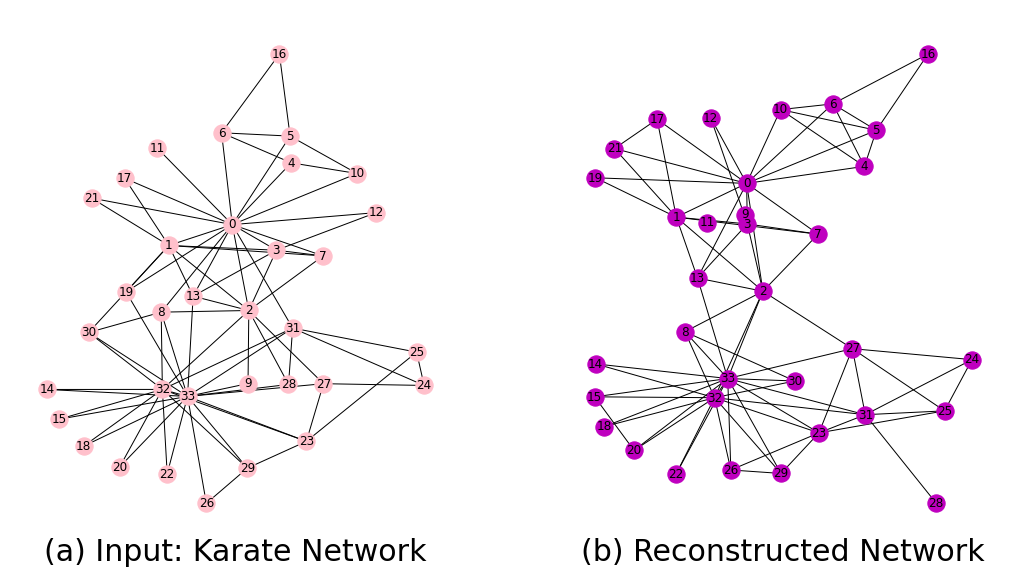

In [85]:
plt.figure(figsize=(18, 10))
grid=plt.GridSpec(1,2)

AX0 = plt.subplot(grid[0, 0])
true_pos=nx.kamada_kawai_layout(G_true)
nx.draw(G_true,true_pos,with_labels = True,node_color = 'pink',node_size = 300, width=1, ax=AX0)
plt.title("(a) Input: Karate Network",fontsize=30,y=-0.03)

AX1 = plt.subplot(grid[0, 1])
pre_pos=nx.kamada_kawai_layout(G_predict)
nx.draw(G_predict, pre_pos, with_labels=True, node_color='m', node_size = 300, width=1, ax=AX1)
plt.title("(b) Reconstructed Network",fontsize=30,y=-0.03)

#plt.savefig("karate_two.pdf",bbox_inches='tight')
plt.show()

In [91]:
pd.DataFrame(NS).to_excel("karate_recons.xlsx",header=None,index=None)

In [30]:
dataset = KarateClub()
data = dataset[0]
edges = data.edge_index

data = edges.numpy()

pd_data = pd.DataFrame(data[0])
pd_data['id_2'] = data[1]

pd_data.to_csv('datasets/karate_edges.txt', header=None, index=False, sep=' ')